# LSTM

## import library

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import random

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.metrics import F1Score

import matplotlib.pyplot as plt

SEED = 123
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)

np.random.seed(SEED)

tf.random.set_seed(SEED)

os.environ['TF_DETERMINISTIC_OPS'] = '1'

## import dataset

In [3]:
# train : https://drive.google.com/file/d/1RcbaFl6aLCkb5eK2C50KDyUeiC0d7hFQ/view?usp=drive_link
# val   : https://drive.google.com/file/d/10-F53KkWv8GAlJuctFvjQxVWES6YHsvA/view?usp=drive_link
# test  : https://drive.google.com/file/d/1psAH0ccdyFca0wjSUVuoqTdXCDJSxe0Z/view?usp=drive_link
train = pd.read_csv("https://drive.google.com/uc?id=1RcbaFl6aLCkb5eK2C50KDyUeiC0d7hFQ")
val = pd.read_csv("https://drive.google.com/uc?id=10-F53KkWv8GAlJuctFvjQxVWES6YHsvA")
test = pd.read_csv("https://drive.google.com/uc?id=1psAH0ccdyFca0wjSUVuoqTdXCDJSxe0Z")

## EDA

In [ ]:
# Data shape
print("Train shape:", train.shape)
print("Val shape  :", train.shape)
print("Test shape :", train.shape)

Train shape: (500, 3)
Val shape  : (500, 3)
Test shape : (500, 3)


In [ ]:
# Unique value
print("Train unique:", train["label"].unique())
print("Val unique:", val["label"].unique())
print("Test unique:", test["label"].unique())

Train unique: ['neutral' 'positive' 'negative']
Val unique: ['neutral' 'negative' 'positive']
Test unique: ['positive' 'neutral' 'negative']


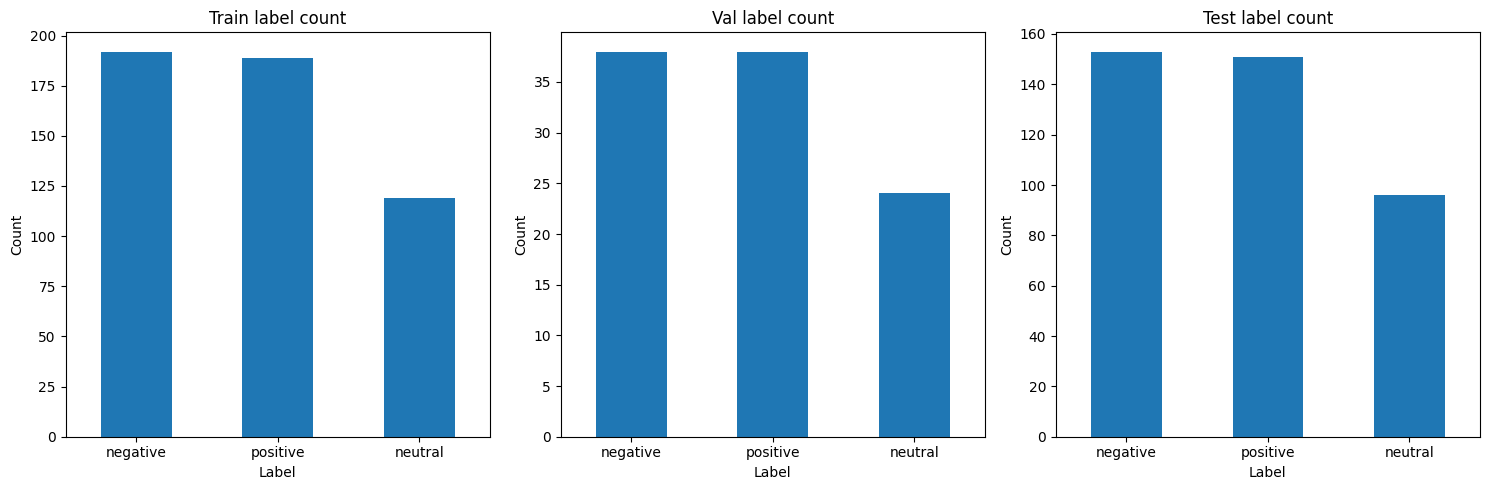

In [ ]:
# Unique values count
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
train['label'].value_counts().plot(kind='bar', ax=ax[0])
val['label'].value_counts().plot(kind='bar', ax=ax[1])
test['label'].value_counts().plot(kind='bar', ax=ax[2])
ax[0].set_title("Train label count")
ax[0].set_xlabel("Label")
ax[0].set_ylabel("Count")
ax[0].tick_params(axis='x', rotation=0)

ax[1].set_title("Val label count")
ax[1].set_xlabel("Label")
ax[1].set_ylabel("Count")
ax[1].tick_params(axis='x', rotation=0)

ax[2].set_title("Test label count")
ax[2].set_xlabel("Label")
ax[2].set_ylabel("Count")
ax[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
# Duplicate check
train.duplicated().sum(), val.duplicated().sum(), test.duplicated().sum()

(np.int64(0), np.int64(0), np.int64(0))

In [ ]:
# check nan values
train.isna().sum(), val.isna().sum(), test.isna().sum()

(id       0
 text     0
 label    0
 dtype: int64,
 id       0
 text     0
 label    0
 dtype: int64,
 id       0
 text     0
 label    0
 dtype: int64)

## split data (input-output)

In [4]:
x_train = train['text']
y_train = train['label']

x_val = val['text']
y_val = val['label']

x_test = test['text']
y_test = test['label']

## preprocess

In [ ]:
a = [len(x_train[i].split()) for i in range(len(x_train))]
b = [len(x_val[i].split()) for i in range(len(x_val))]
c = [len(x_test[i].split()) for i in range(len(x_test))]

In [ ]:
print("Max sequence:", max(a), max(b), max(c))

Max sequence: 77 61 71


In [ ]:
# Tokenization
max_token = 5000
seq_len = 70

vectorizer = TextVectorization(max_tokens=max_token, output_sequence_length=seq_len)
vectorizer.adapt(x_train)
print("Max vocab:", len(vectorizer.get_vocabulary()))

Max vocab: 2836


In [6]:
# Encode y label
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

In [7]:
# Tokenization
max_token = 3000
seq_len = 80

vectorizer = TextVectorization(max_tokens=max_token, output_sequence_length=seq_len)
vectorizer.adapt(x_train)

x_train_tokenized = vectorizer(x_train)
x_val_tokenized = vectorizer(x_val)
x_test_tokenized = vectorizer(x_test)

## modelling

### Pengujian Hyperparameter LSTM

#### pengaruh jumlah layer

1. 1 layer
2. 3 layer
3. 5 layer

##### variasi 1

In [ ]:
tf.keras.backend.clear_session()

batch_size = 64
features = 64
lr = 0.0001
units = 32
rate = 0.4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

lstm = Sequential()
lstm.add(Input(shape=(seq_len,)))
lstm.add(Embedding(input_dim=max_token, output_dim=features))  # shape: (batch, seq_len, features)
lstm.add(LSTM(units, return_sequences=False))
lstm.add(Dropout(rate))
lstm.add(Dense(3, activation='softmax'))  # 3 classes: negative (0), neutral (1), positive (1)
lstm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(lstm.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 64)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,515 (798.89 KB)

 Trainable params: 204,515 (798.89 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# train
epoch = 40
lstm.fit(x_train_tokenized, y_train_encoded, batch_size=batch_size, epochs=epoch, validation_data=(x_val_tokenized, y_val_encoded))

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.2790 - loss: 1.1030 - val_accuracy: 0.3800 - val_loss: 1.0988
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3336 - loss: 1.0968 - val_accuracy: 0.3800 - val_loss: 1.0946
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3604 - loss: 1.0952 - val_accuracy: 0.3800 - val_loss: 1.0912
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4002 - loss: 1.0900 - val_accuracy: 0.3800 - val_loss: 1.0883
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.3730 - loss: 1.0845 - val_accuracy: 0.3800 - val_loss: 1.0860
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.3872 - loss: 1.0857 - val_accuracy: 0.3800 - val_loss: 1.0841
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.4055 - loss: 1.0835 - val_accuracy: 0.3800 - val_loss: 1.0826
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.3915 - loss: 1.0827 - val_accuracy: 0.3800 - val_loss: 1.081

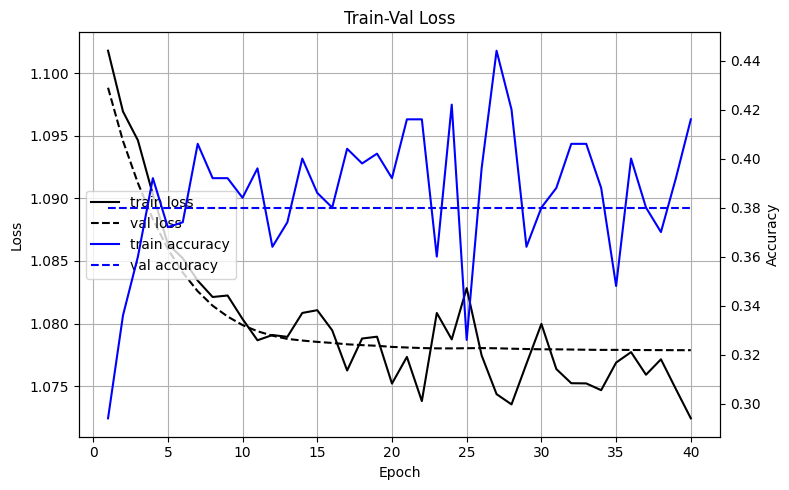

In [ ]:
train_loss = lstm.history.history['loss']
val_loss = lstm.history.history['val_loss']
train_acc = lstm.history.history['accuracy']
val_acc = lstm.history.history['val_accuracy']

fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()

ax.plot(np.arange(1, epoch+1), train_loss, label='train loss', color="black", linestyle="-")
ax.plot(np.arange(1, epoch+1), val_loss, label='val loss', color="black", linestyle="--")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax2.plot(np.arange(1, epoch+1), train_acc, label='train accuracy', color="blue", linestyle="-")
ax2.plot(np.arange(1, epoch+1), val_acc, label='val accuracy', color="blue", linestyle="--")
ax2.set_ylabel('Accuracy')

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc=6)

ax.set_title('Train-Val Loss')
ax.grid()

plt.tight_layout()
plt.show()

In [ ]:
# save model
lstm.save_weights('lstm1.weights.h5')

In [ ]:
# load model
#lstm_w =
lstm.load_weights('lstm.weights.h5')

In [ ]:
eval = lstm.evaluate(x_test_tokenized, y_test_encoded, return_dict=True)
test_acc = eval["accuracy"]
test_loss = eval["loss"]
print(f"Test loss     : {test_loss}")
print(f"Test accuracy : {test_acc}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3540 - loss: 1.0973
Test loss     : 1.0778168439865112
Test accuracy : 0.38499999046325684


In [ ]:
# one hot
ohe = OneHotEncoder()
y_test_encoded_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()

# prediction
y_pred = lstm.predict(x_test_tokenized)

# F1 score
metric = F1Score(average="macro")
metric.update_state(y_test_encoded_ohe, y_pred)
test_f1 = metric.result().numpy()
print("Macro F1-score:", test_f1)  # perfect score: 1

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Macro F1-score: 0.18916857


In [ ]:
from sklearn.metrics import classification_report
y_pred_labels = np.argmax(y_pred, axis=1)
print(classification_report(y_test_encoded, y_pred_labels))

              precision    recall  f1-score   support

           0       0.38      1.00      0.55       153
           1       0.00      0.00      0.00        96
           2       1.00      0.01      0.01       151

    accuracy                           0.39       400
   macro avg       0.46      0.34      0.19       400
weighted avg       0.52      0.39      0.22       400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### variasi 2

In [ ]:
tf.keras.backend.clear_session()

batch_size = 64
features = 64
lr = 0.0001
units = 32
rate = 0.4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

lstm = Sequential()
lstm.add(Input(shape=(seq_len,)))
lstm.add(Embedding(input_dim=max_token, output_dim=features))  # shape: (batch, seq_len, features)
lstm.add(LSTM(units, return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.7), return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.5), return_sequences=False))
lstm.add(Dropout(rate))
lstm.add(Dense(3, activation='softmax'))  # 3 classes: negative (0), neutral (1), positive (1)
lstm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(lstm.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 64)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 80, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 80, 22)         │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80, 22)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,803 (827.36 KB)

 Trainable params: 211,803 (827.36 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# train
epoch = 40
lstm.fit(x_train_tokenized, y_train_encoded, batch_size=batch_size, epochs=epoch, validation_data=(x_val_tokenized, y_val_encoded))

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.3145 - loss: 1.0994 - val_accuracy: 0.3800 - val_loss: 1.0976
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.3826 - loss: 1.0975 - val_accuracy: 0.3800 - val_loss: 1.0952
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.3619 - loss: 1.0951 - val_accuracy: 0.3800 - val_loss: 1.0931
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.3704 - loss: 1.0938 - val_accuracy: 0.3800 - val_loss: 1.0913
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.3871 - loss: 1.0910 - val_accuracy: 0.3800 - val_loss: 1.0896
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.3984 - loss: 1.0861 - val_accuracy: 0.3800 - val_loss: 1.0877
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.3970 - loss: 1.0870 - val_accuracy: 0.3800 - val_loss: 1.0859
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.3856 - loss: 1.0862 - val_accuracy: 0.3800 - val_loss:

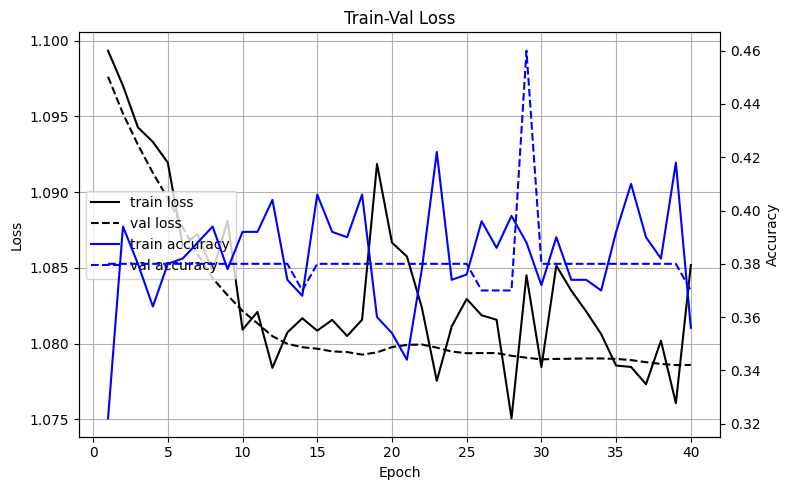

In [ ]:
train_loss = lstm.history.history['loss']
val_loss = lstm.history.history['val_loss']
train_acc = lstm.history.history['accuracy']
val_acc = lstm.history.history['val_accuracy']

fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()

ax.plot(np.arange(1, epoch+1), train_loss, label='train loss', color="black", linestyle="-")
ax.plot(np.arange(1, epoch+1), val_loss, label='val loss', color="black", linestyle="--")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax2.plot(np.arange(1, epoch+1), train_acc, label='train accuracy', color="blue", linestyle="-")
ax2.plot(np.arange(1, epoch+1), val_acc, label='val accuracy', color="blue", linestyle="--")
ax2.set_ylabel('Accuracy')

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc=6)

ax.set_title('Train-Val Loss')
ax.grid()

plt.tight_layout()
plt.show()

In [ ]:
# save model
lstm.save_weights('lstm2.weights.h5')

In [ ]:
# load model
#lstm_w =
lstm.load_weights('lstm.weights.h5')

In [ ]:
eval = lstm.evaluate(x_test_tokenized, y_test_encoded, return_dict=True)
test_acc = eval["accuracy"]
test_loss = eval["loss"]
print(f"Test loss     : {test_loss}")
print(f"Test accuracy : {test_acc}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3954 - loss: 1.0946
Test loss     : 1.0783538818359375
Test accuracy : 0.41749998927116394


In [ ]:
# one hot
ohe = OneHotEncoder()
y_test_encoded_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()

# prediction
y_pred = lstm.predict(x_test_tokenized)

# F1 score
metric = F1Score(average="macro")
metric.update_state(y_test_encoded_ohe, y_pred)
test_f1 = metric.result().numpy()
print("Macro F1-score:", test_f1)  # perfect score: 1

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step
Macro F1-score: 0.26109695


In [ ]:
from sklearn.metrics import classification_report
y_pred_labels = np.argmax(y_pred, axis=1)
print(classification_report(y_test_encoded, y_pred_labels))

              precision    recall  f1-score   support

           0       0.40      0.96      0.56       153
           1       0.00      0.00      0.00        96
           2       0.69      0.13      0.22       151

    accuracy                           0.42       400
   macro avg       0.36      0.36      0.26       400
weighted avg       0.41      0.42      0.30       400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### variasi 3

In [ ]:
tf.keras.backend.clear_session()

batch_size = 64
features = 64
lr = 0.0001
units = 32
rate = 0.4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

lstm = Sequential()
lstm.add(Input(shape=(seq_len,)))
lstm.add(Embedding(input_dim=max_token, output_dim=features))  # shape: (batch, seq_len, features)
lstm.add(LSTM(units, return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.7), return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.7), return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.5), return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.5), return_sequences=False))
lstm.add(Dropout(rate))
lstm.add(Dense(3, activation='softmax'))  # 3 classes: negative (0), neutral (1), positive (1)
lstm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(lstm.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 64)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 80, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 80, 22)         │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80, 22)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 80, 22)         │         3,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80, 22)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 80, 16)         │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 80, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,875 (851.07 KB)

 Trainable params: 217,875 (851.07 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# train
epoch = 40
lstm.fit(x_train_tokenized, y_train_encoded, batch_size=batch_size, epochs=epoch, validation_data=(x_val_tokenized, y_val_encoded))

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 383ms/step - accuracy: 0.3778 - loss: 1.0974 - val_accuracy: 0.3800 - val_loss: 1.0964
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.3706 - loss: 1.0965 - val_accuracy: 0.3800 - val_loss: 1.0950
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.3782 - loss: 1.0951 - val_accuracy: 0.3800 - val_loss: 1.0937
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.4053 - loss: 1.0922 - val_accuracy: 0.3800 - val_loss: 1.0923
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - accuracy: 0.3950 - loss: 1.0914 - val_accuracy: 0.3800 - val_loss: 1.0907
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.3861 - loss: 1.0910 - val_accuracy: 0.3800 - val_loss: 1.0891
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.3941 - loss: 1.0905 - val_accuracy: 0.3800 - val_loss: 1.0877
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.4053 - loss: 1.0890 - val_accuracy: 0.3800 - val_loss

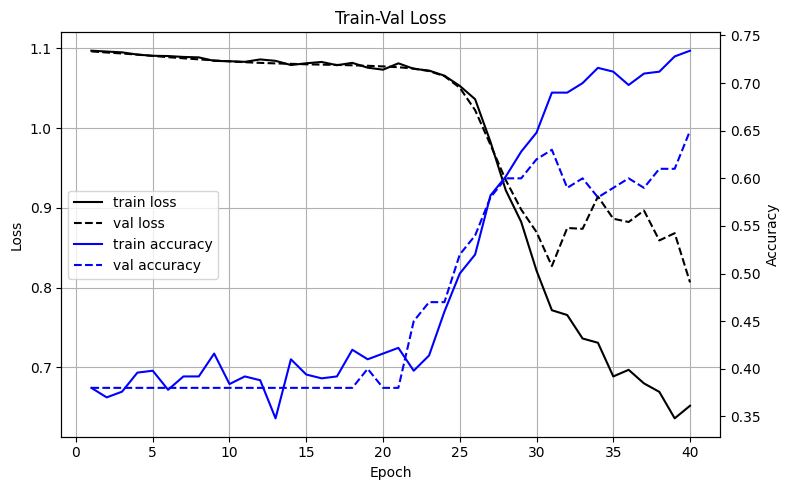

In [ ]:
train_loss = lstm.history.history['loss']
val_loss = lstm.history.history['val_loss']
train_acc = lstm.history.history['accuracy']
val_acc = lstm.history.history['val_accuracy']

fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()

ax.plot(np.arange(1, epoch+1), train_loss, label='train loss', color="black", linestyle="-")
ax.plot(np.arange(1, epoch+1), val_loss, label='val loss', color="black", linestyle="--")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax2.plot(np.arange(1, epoch+1), train_acc, label='train accuracy', color="blue", linestyle="-")
ax2.plot(np.arange(1, epoch+1), val_acc, label='val accuracy', color="blue", linestyle="--")
ax2.set_ylabel('Accuracy')

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc=6)

ax.set_title('Train-Val Loss')
ax.grid()

plt.tight_layout()
plt.show()

In [ ]:
# save model
lstm.save_weights('lstm3.weights.h5')

In [ ]:
# load model
#lstm_w =
lstm.load_weights('lstm.weights.h5')

In [ ]:
eval = lstm.evaluate(x_test_tokenized, y_test_encoded, return_dict=True)
test_acc = eval["accuracy"]
test_loss = eval["loss"]
print(f"Test loss     : {test_loss}")
print(f"Test accuracy : {test_acc}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5835 - loss: 0.8883
Test loss     : 0.8685092926025391
Test accuracy : 0.6150000095367432


In [ ]:
# one hot
ohe = OneHotEncoder()
y_test_encoded_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()

# prediction
y_pred = lstm.predict(x_test_tokenized)

# F1 score
metric = F1Score(average="macro")
metric.update_state(y_test_encoded_ohe, y_pred)
test_f1 = metric.result().numpy()
print("Macro F1-score:", test_f1)  # perfect score: 1

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step
Macro F1-score: 0.4673768


In [ ]:
from sklearn.metrics import classification_report
y_pred_labels = np.argmax(y_pred, axis=1)
print(classification_report(y_test_encoded, y_pred_labels))

              precision    recall  f1-score   support

           0       0.53      0.73      0.61       153
           1       0.00      0.00      0.00        96
           2       0.70      0.89      0.79       151

    accuracy                           0.61       400
   macro avg       0.41      0.54      0.47       400
weighted avg       0.47      0.61      0.53       400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### pengaruh banyak cell LSTM

- variasi 1: 16
- variasi 2: 128
- variasi 3: 512

##### variasi 1

In [ ]:
tf.keras.backend.clear_session()

batch_size = 64
features = 64
lr = 0.0001
units = 16
rate = 0.4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

lstm = Sequential()
lstm.add(Input(shape=(seq_len,)))
lstm.add(Embedding(input_dim=max_token, output_dim=features))  # shape: (batch, seq_len, features)
lstm.add(LSTM(units, return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.7), return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.7), return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.5), return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.5), return_sequences=False))
lstm.add(Dropout(rate))
lstm.add(Dense(3, activation='softmax'))  # 3 classes: negative (0), neutral (1), positive (1)
lstm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(lstm.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 64)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 80, 16)         │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 80, 11)         │         1,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 80, 11)         │         1,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 80, 8)          │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 80, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,639 (783.75 KB)

 Trainable params: 200,639 (783.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# train
epoch = 40
lstm.fit(x_train_tokenized, y_train_encoded, batch_size=batch_size, epochs=epoch, validation_data=(x_val_tokenized, y_val_encoded))

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.2701 - loss: 1.1008 - val_accuracy: 0.2700 - val_loss: 1.0997
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.3330 - loss: 1.0989 - val_accuracy: 0.3800 - val_loss: 1.0980
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.3648 - loss: 1.0973 - val_accuracy: 0.3800 - val_loss: 1.0967
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.3782 - loss: 1.0962 - val_accuracy: 0.3800 - val_loss: 1.0955
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - accuracy: 0.3954 - loss: 1.0941 - val_accuracy: 0.3800 - val_loss: 1.0942
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.3745 - loss: 1.0950 - val_accuracy: 0.3800 - val_loss: 1.0932
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.3733 - loss: 1.0927 - val_accuracy: 0.3800 - val_loss: 1.0922
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.3852 - loss: 1.0929 - val_accuracy: 0.3800 - val_loss

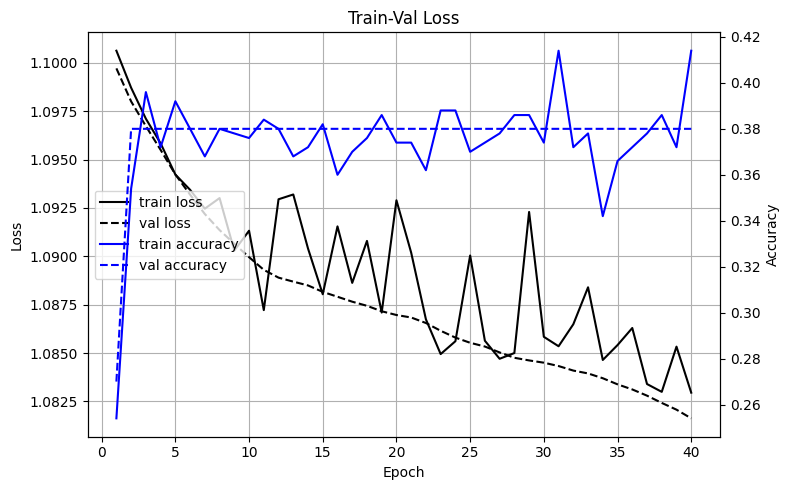

In [ ]:
train_loss = lstm.history.history['loss']
val_loss = lstm.history.history['val_loss']
train_acc = lstm.history.history['accuracy']
val_acc = lstm.history.history['val_accuracy']

fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()

ax.plot(np.arange(1, epoch+1), train_loss, label='train loss', color="black", linestyle="-")
ax.plot(np.arange(1, epoch+1), val_loss, label='val loss', color="black", linestyle="--")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax2.plot(np.arange(1, epoch+1), train_acc, label='train accuracy', color="blue", linestyle="-")
ax2.plot(np.arange(1, epoch+1), val_acc, label='val accuracy', color="blue", linestyle="--")
ax2.set_ylabel('Accuracy')

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc=6)

ax.set_title('Train-Val Loss')
ax.grid()

plt.tight_layout()
plt.show()

In [ ]:
# save model
lstm.save_weights('lstm1_hid.weights.h5')

In [ ]:
# load model
#lstm_w =
lstm.load_weights('lstm.weights.h5')

In [ ]:
eval = lstm.evaluate(x_test_tokenized, y_test_encoded, return_dict=True)
test_acc = eval["accuracy"]
test_loss = eval["loss"]
print(f"Test loss     : {test_loss}")
print(f"Test accuracy : {test_acc}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3657 - loss: 1.0856
Test loss     : 1.0794657468795776
Test accuracy : 0.3774999976158142


In [ ]:
# one hot
ohe = OneHotEncoder()
y_test_encoded_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()

# prediction
y_pred = lstm.predict(x_test_tokenized)

# F1 score
metric = F1Score(average="macro")
metric.update_state(y_test_encoded_ohe, y_pred)
test_f1 = metric.result().numpy()
print("Macro F1-score:", test_f1)  # perfect score: 1

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step
Macro F1-score: 0.18269809


In [ ]:
from sklearn.metrics import classification_report
y_pred_labels = np.argmax(y_pred, axis=1)
print(classification_report(y_test_encoded, y_pred_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       153
           1       0.00      0.00      0.00        96
           2       0.38      1.00      0.55       151

    accuracy                           0.38       400
   macro avg       0.13      0.33      0.18       400
weighted avg       0.14      0.38      0.21       400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### variasi 2

In [ ]:
tf.keras.backend.clear_session()

batch_size = 64
features = 64
lr = 0.0001
units = 128
rate = 0.4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

lstm = Sequential()
lstm.add(Input(shape=(seq_len,)))
lstm.add(Embedding(input_dim=max_token, output_dim=features))  # shape: (batch, seq_len, features)
lstm.add(LSTM(units, return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.7), return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.7), return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.5), return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.5), return_sequences=False))
lstm.add(Dropout(rate))
lstm.add(Dense(3, activation='softmax'))  # 3 classes: negative (0), neutral (1), positive (1)
lstm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(lstm.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 64)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 80, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 80, 89)         │        77,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80, 89)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 80, 89)         │        63,724 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80, 89)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 80, 64)         │        39,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 80, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 504,791 (1.93 MB)

 Trainable params: 504,791 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# train
epoch = 40
lstm.fit(x_train_tokenized, y_train_encoded, batch_size=batch_size, epochs=epoch, validation_data=(x_val_tokenized, y_val_encoded))

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 842ms/step - accuracy: 0.3120 - loss: 1.0990 - val_accuracy: 0.3800 - val_loss: 1.0965
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 859ms/step - accuracy: 0.3711 - loss: 1.0959 - val_accuracy: 0.3700 - val_loss: 1.0932
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 562ms/step - accuracy: 0.3958 - loss: 1.0923 - val_accuracy: 0.3800 - val_loss: 1.0892
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 564ms/step - accuracy: 0.3735 - loss: 1.0884 - val_accuracy: 0.3800 - val_loss: 1.0842
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 848ms/step - accuracy: 0.4024 - loss: 1.0796 - val_accuracy: 0.3800 - val_loss: 1.0801
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 564ms/step - accuracy: 0.4281 - loss: 1.0798 - val_accuracy: 0.3800 - val_loss: 1.0799
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 576ms/step - accuracy: 0.3982 - loss: 1.0753 - val_accuracy: 0.3800 - val_loss: 1.0793
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 728ms/step - accuracy: 0.3861 - loss: 1.0791 - val_accuracy: 0.3800 - val_los

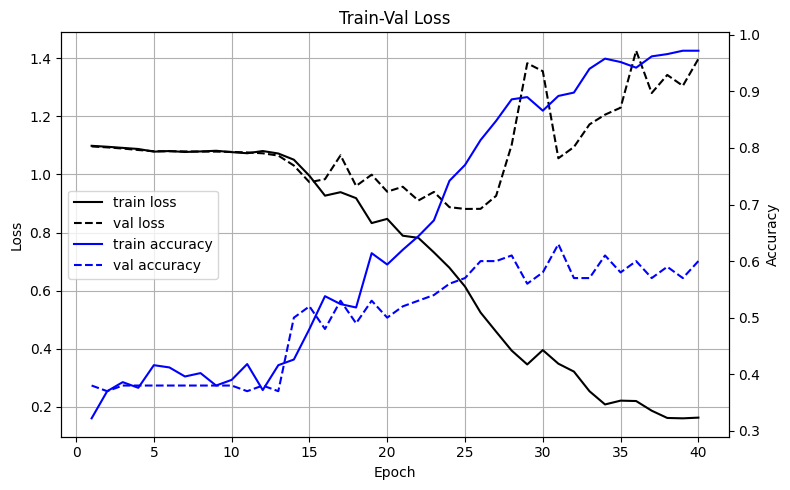

In [ ]:
train_loss = lstm.history.history['loss']
val_loss = lstm.history.history['val_loss']
train_acc = lstm.history.history['accuracy']
val_acc = lstm.history.history['val_accuracy']

fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()

ax.plot(np.arange(1, epoch+1), train_loss, label='train loss', color="black", linestyle="-")
ax.plot(np.arange(1, epoch+1), val_loss, label='val loss', color="black", linestyle="--")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax2.plot(np.arange(1, epoch+1), train_acc, label='train accuracy', color="blue", linestyle="-")
ax2.plot(np.arange(1, epoch+1), val_acc, label='val accuracy', color="blue", linestyle="--")
ax2.set_ylabel('Accuracy')

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc=6)

ax.set_title('Train-Val Loss')
ax.grid()

plt.tight_layout()
plt.show()

In [ ]:
# save model
lstm.save_weights('lstm2_hid.weights.h5')

In [ ]:
# load model
#lstm_w =
lstm.load_weights('lstm.weights.h5')

In [ ]:
eval = lstm.evaluate(x_test_tokenized, y_test_encoded, return_dict=True)
test_acc = eval["accuracy"]
test_loss = eval["loss"]
print(f"Test loss     : {test_loss}")
print(f"Test accuracy : {test_acc}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.6396 - loss: 1.1822
Test loss     : 1.11597740650177
Test accuracy : 0.6625000238418579


In [ ]:
# one hot
ohe = OneHotEncoder()
y_test_encoded_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()

# prediction
y_pred = lstm.predict(x_test_tokenized)

# F1 score
metric = F1Score(average="macro")
metric.update_state(y_test_encoded_ohe, y_pred)
test_f1 = metric.result().numpy()
print("Macro F1-score:", test_f1)  # perfect score: 1

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step
Macro F1-score: 0.635426


In [ ]:
from sklearn.metrics import classification_report
y_pred_labels = np.argmax(y_pred, axis=1)
print(classification_report(y_test_encoded, y_pred_labels))

              precision    recall  f1-score   support

           0       0.56      0.75      0.64       153
           1       0.64      0.39      0.48        96
           2       0.81      0.75      0.78       151

    accuracy                           0.66       400
   macro avg       0.67      0.63      0.64       400
weighted avg       0.68      0.66      0.66       400



##### variasi 3

In [ ]:
tf.keras.backend.clear_session()

batch_size = 64
features = 64
lr = 0.0001
units = 512
rate = 0.4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

lstm = Sequential()
lstm.add(Input(shape=(seq_len,)))
lstm.add(Embedding(input_dim=max_token, output_dim=features))  # shape: (batch, seq_len, features)
lstm.add(LSTM(units, return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.7), return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.7), return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.5), return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.5), return_sequences=False))
lstm.add(Dropout(rate))
lstm.add(Dense(3, activation='softmax'))  # 3 classes: negative (0), neutral (1), positive (1)
lstm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(lstm.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 64)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 80, 512)        │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 80, 358)        │     1,247,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80, 358)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 80, 358)        │     1,026,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80, 358)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 80, 256)        │       629,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 80, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,803,555 (18.32 MB)

 Trainable params: 4,803,555 (18.32 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# train
epoch = 40
lstm.fit(x_train_tokenized, y_train_encoded, batch_size=batch_size, epochs=epoch, validation_data=(x_val_tokenized, y_val_encoded))

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.3547 - loss: 1.0968 - val_accuracy: 0.3800 - val_loss: 1.0879
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.3683 - loss: 1.0857 - val_accuracy: 0.3800 - val_loss: 1.0815
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.3711 - loss: 1.0820 - val_accuracy: 0.3800 - val_loss: 1.0795
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.3902 - loss: 1.0795 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.3858 - loss: 1.0762 - val_accuracy: 0.3800 - val_loss: 1.0771
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.4126 - loss: 1.0742 - val_accuracy: 0.3700 - val_loss: 1.0715
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.4107 - loss: 1.0588 - val_accuracy: 0.4600 - val_loss: 0.9943
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.5300 - loss: 0.9542 - val_accuracy: 0.4700 - val_loss: 1.0306
Epoch 9/

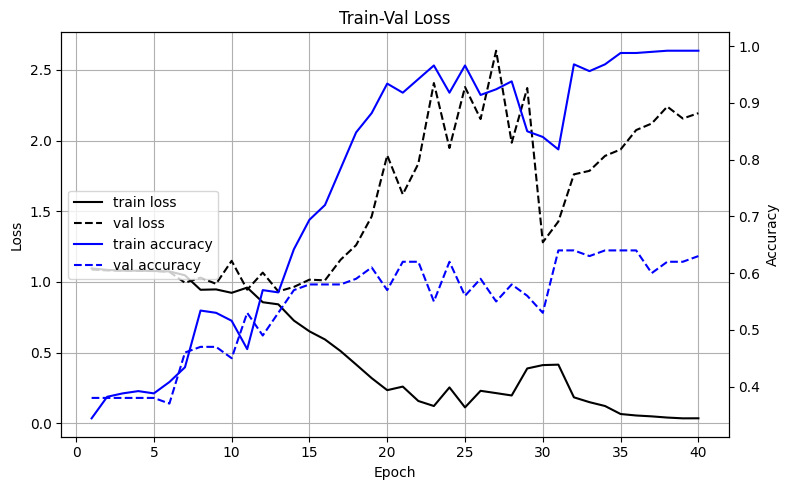

In [ ]:
train_loss = lstm.history.history['loss']
val_loss = lstm.history.history['val_loss']
train_acc = lstm.history.history['accuracy']
val_acc = lstm.history.history['val_accuracy']

fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()

ax.plot(np.arange(1, epoch+1), train_loss, label='train loss', color="black", linestyle="-")
ax.plot(np.arange(1, epoch+1), val_loss, label='val loss', color="black", linestyle="--")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax2.plot(np.arange(1, epoch+1), train_acc, label='train accuracy', color="blue", linestyle="-")
ax2.plot(np.arange(1, epoch+1), val_acc, label='val accuracy', color="blue", linestyle="--")
ax2.set_ylabel('Accuracy')

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc=6)

ax.set_title('Train-Val Loss')
ax.grid()

plt.tight_layout()
plt.show()

In [ ]:
# save model
lstm.save_weights('lstm3_hid.weights.h5')

In [ ]:
# load model
#lstm_w =
lstm.load_weights('lstm.weights.h5')

In [ ]:
eval = lstm.evaluate(x_test_tokenized, y_test_encoded, return_dict=True)
test_acc = eval["accuracy"]
test_loss = eval["loss"]
print(f"Test loss     : {test_loss}")
print(f"Test accuracy : {test_acc}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 795ms/step - accuracy: 0.6020 - loss: 2.3595
Test loss     : 2.2762413024902344
Test accuracy : 0.5975000262260437


In [ ]:
# one hot
ohe = OneHotEncoder()
y_test_encoded_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()

# prediction
y_pred = lstm.predict(x_test_tokenized)

# F1 score
metric = F1Score(average="macro")
metric.update_state(y_test_encoded_ohe, y_pred)
test_f1 = metric.result().numpy()
print("Macro F1-score:", test_f1)  # perfect score: 1

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 769ms/step
Macro F1-score: 0.5542815


In [ ]:
from sklearn.metrics import classification_report
y_pred_labels = np.argmax(y_pred, axis=1)
print(classification_report(y_test_encoded, y_pred_labels))

              precision    recall  f1-score   support

           0       0.53      0.56      0.55       153
           1       0.63      0.28      0.39        96
           2       0.65      0.83      0.73       151

    accuracy                           0.60       400
   macro avg       0.60      0.56      0.55       400
weighted avg       0.60      0.60      0.58       400



#### pengaruh uni/bidirectional

##### variasi 1 (unidirectional)

In [ ]:
tf.keras.backend.clear_session()

batch_size = 78
features = 64
lr = 0.0001
units = 128
rate = 0.4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

lstm = Sequential()
lstm.add(Input(shape=(seq_len,)))
lstm.add(Embedding(input_dim=max_token, output_dim=features))  # shape: (batch, seq_len, features)
lstm.add(LSTM(units, return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.7), return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.7), return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.5), return_sequences=True))
lstm.add(Dropout(rate))
lstm.add(LSTM(int(units*0.5), return_sequences=False))
lstm.add(Dropout(rate))
lstm.add(Dense(3, activation='softmax'))  # 3 classes: negative (0), neutral (1), positive (1)
lstm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(lstm.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 64)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 80, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 80, 89)         │        77,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80, 89)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 80, 89)         │        63,724 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80, 89)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 80, 64)         │        39,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 80, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 504,791 (1.93 MB)

 Trainable params: 504,791 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# train
epoch = 40
lstm.fit(x_train_tokenized, y_train_encoded, batch_size=batch_size, epochs=epoch, validation_data=(x_val_tokenized, y_val_encoded))

Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3012 - loss: 1.0992 - val_accuracy: 0.3700 - val_loss: 1.0961
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 616ms/step - accuracy: 0.3869 - loss: 1.0953 - val_accuracy: 0.3800 - val_loss: 1.0923
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 947ms/step - accuracy: 0.3776 - loss: 1.0913 - val_accuracy: 0.3800 - val_loss: 1.0876
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3831 - loss: 1.0876 - val_accuracy: 0.3800 - val_loss: 1.0833
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3995 - loss: 1.0833 - val_accuracy: 0.3800 - val_loss: 1.0805
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3483 - loss: 1.0856 - val_accuracy: 0.3800 - val_loss: 1.0799
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3888 - loss: 1.0821 - val_accuracy: 0.3800 - val_loss: 1.0796
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3387 - loss: 1.0851 - val_accuracy: 0.5000 - val_loss: 1.0795
Epoch 

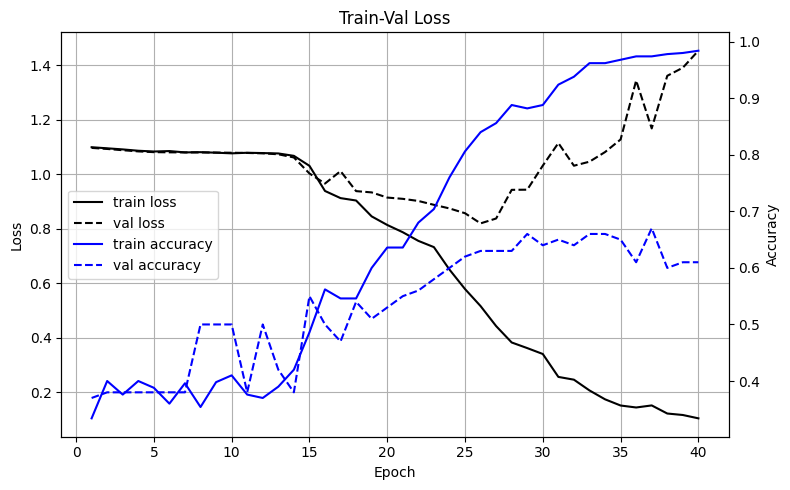

In [ ]:
train_loss = lstm.history.history['loss']
val_loss = lstm.history.history['val_loss']
train_acc = lstm.history.history['accuracy']
val_acc = lstm.history.history['val_accuracy']

fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()

ax.plot(np.arange(1, epoch+1), train_loss, label='train loss', color="black", linestyle="-")
ax.plot(np.arange(1, epoch+1), val_loss, label='val loss', color="black", linestyle="--")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax2.plot(np.arange(1, epoch+1), train_acc, label='train accuracy', color="blue", linestyle="-")
ax2.plot(np.arange(1, epoch+1), val_acc, label='val accuracy', color="blue", linestyle="--")
ax2.set_ylabel('Accuracy')

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc=6)

ax.set_title('Train-Val Loss')
ax.grid()

plt.tight_layout()
plt.show()

In [ ]:
# save model
lstm.save_weights('lstm_uni.weights.h5')

In [ ]:
# load model
#lstm_w =
lstm.load_weights('lstm.weights.h5')

In [ ]:
eval = lstm.evaluate(x_test_tokenized, y_test_encoded, return_dict=True)
test_acc = eval["accuracy"]
test_loss = eval["loss"]
print(f"Test loss     : {test_loss}")
print(f"Test accuracy : {test_acc}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.6892 - loss: 1.0880
Test loss     : 1.1714838743209839
Test accuracy : 0.6675000190734863


In [ ]:
# one hot
ohe = OneHotEncoder()
y_test_encoded_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()

# prediction
y_pred = lstm.predict(x_test_tokenized)

# F1 score
metric = F1Score(average="macro")
metric.update_state(y_test_encoded_ohe, y_pred)
test_f1 = metric.result().numpy()
print("Macro F1-score:", test_f1)  # perfect score: 1

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step
Macro F1-score: 0.6629842


In [ ]:
from sklearn.metrics import classification_report
y_pred_labels = np.argmax(y_pred, axis=1)
print(classification_report(y_test_encoded, y_pred_labels))

              precision    recall  f1-score   support

           0       0.61      0.54      0.57       153
           1       0.54      0.71      0.62        96
           2       0.84      0.77      0.80       151

    accuracy                           0.67       400
   macro avg       0.66      0.67      0.66       400
weighted avg       0.68      0.67      0.67       400



##### variasi 2 (bidirectional)

In [ ]:
tf.keras.backend.clear_session()

batch_size = 78
features = 64
lr = 0.0001
units = 128
rate = 0.4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

lstm = Sequential()
lstm.add(Input(shape=(seq_len,)))
lstm.add(Embedding(input_dim=max_token, output_dim=features))  # shape: (batch, seq_len, features)
lstm.add(Bidirectional(LSTM(units, return_sequences=True)))
lstm.add(Dropout(rate))
lstm.add(Bidirectional(LSTM(int(units*0.7), return_sequences=True)))
lstm.add(Dropout(rate))
lstm.add(Bidirectional(LSTM(int(units*0.7), return_sequences=True)))
lstm.add(Dropout(rate))
lstm.add(Bidirectional(LSTM(int(units*0.5), return_sequences=True)))
lstm.add(Dropout(rate))
lstm.add(Bidirectional(LSTM(int(units*0.5), return_sequences=False)))
lstm.add(Dropout(rate))
lstm.add(Dense(3, activation='softmax'))  # 3 classes: negative (0), neutral (1), positive (1)
lstm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(lstm.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 64)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 80, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 80, 178)        │       246,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80, 178)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 80, 178)        │       190,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80, 178)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 80, 128)        │       124,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,050,419 (4.01 MB)

 Trainable params: 1,050,419 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# train
epoch = 40
lstm.fit(x_train_tokenized, y_train_encoded, batch_size=batch_size, epochs=epoch, validation_data=(x_val_tokenized, y_val_encoded))

Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3571 - loss: 1.0972 - val_accuracy: 0.3900 - val_loss: 1.0919
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4291 - loss: 1.0896 - val_accuracy: 0.5000 - val_loss: 1.0841
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4338 - loss: 1.0805 - val_accuracy: 0.5100 - val_loss: 1.0724
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4843 - loss: 1.0692 - val_accuracy: 0.4900 - val_loss: 1.0565
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4533 - loss: 1.0520 - val_accuracy: 0.5200 - val_loss: 1.0309
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4900 - loss: 1.0245 - val_accuracy: 0.5100 - val_loss: 1.0003
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5115 - loss: 0.9851 - val_accuracy: 0.5200 - val_loss: 0.9758
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5598 - loss: 0.9462 - val_accuracy: 0.5100 - val_loss: 0.9661
Epoch 9/

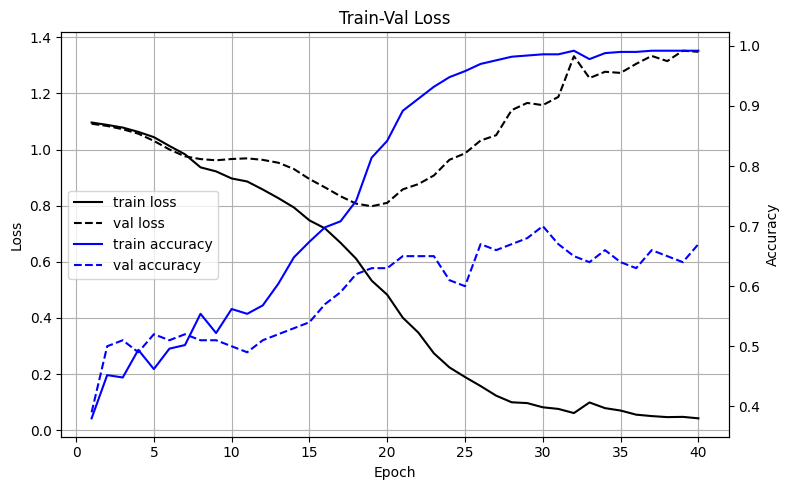

In [ ]:
train_loss = lstm.history.history['loss']
val_loss = lstm.history.history['val_loss']
train_acc = lstm.history.history['accuracy']
val_acc = lstm.history.history['val_accuracy']

fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()

ax.plot(np.arange(1, epoch+1), train_loss, label='train loss', color="black", linestyle="-")
ax.plot(np.arange(1, epoch+1), val_loss, label='val loss', color="black", linestyle="--")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax2.plot(np.arange(1, epoch+1), train_acc, label='train accuracy', color="blue", linestyle="-")
ax2.plot(np.arange(1, epoch+1), val_acc, label='val accuracy', color="blue", linestyle="--")
ax2.set_ylabel('Accuracy')

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc=6)

ax.set_title('Train-Val Loss')
ax.grid()

plt.tight_layout()
plt.show()

In [ ]:
# save model
lstm.save_weights('lstm_bi.weights.h5')

In [ ]:
# load model
#lstm_w =
lstm.load_weights('lstm.weights.h5')

In [ ]:
eval = lstm.evaluate(x_test_tokenized, y_test_encoded, return_dict=True)
test_acc = eval["accuracy"]
test_loss = eval["loss"]
print(f"Test loss     : {test_loss}")
print(f"Test accuracy : {test_acc}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.6792 - loss: 1.3239
Test loss     : 1.314037799835205
Test accuracy : 0.6800000071525574


In [ ]:
# one hot
ohe = OneHotEncoder()
y_test_encoded_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()

# prediction
y_pred = lstm.predict(x_test_tokenized)

# F1 score
metric = F1Score(average="macro")
metric.update_state(y_test_encoded_ohe, y_pred)
test_f1 = metric.result().numpy()
print("Macro F1-score:", test_f1)  # perfect score: 1

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 592ms/step
Macro F1-score: 0.66677165


In [ ]:
from sklearn.metrics import classification_report
y_pred_labels = np.argmax(y_pred, axis=1)
print(classification_report(y_test_encoded, y_pred_labels))

              precision    recall  f1-score   support

           0       0.59      0.65      0.62       153
           1       0.61      0.53      0.57        96
           2       0.82      0.80      0.81       151

    accuracy                           0.68       400
   macro avg       0.67      0.66      0.67       400
weighted avg       0.68      0.68      0.68       400



# LSTM From scratch

In [14]:
# import model from scratch
# https://drive.google.com/file/d/1m6YVnr3kz4xooOHP3gLyJhQZFY1SAlVY/view?usp=drive_link
import gdown

# Download module
url = "https://drive.google.com/uc?id=1m6YVnr3kz4xooOHP3gLyJhQZFY1SAlVY"
gdown.download(url, quiet=True)

# Download weights data
# https://drive.google.com/file/d/1ez-9qO-xeugm4gkMHsDxFBqP_oRgdvGM/view?usp=drive_link
url = "https://drive.google.com/uc?id=1ez-9qO-xeugm4gkMHsDxFBqP_oRgdvGM"
gdown.download(url, quiet=True)

from model import softmax, batch_array, sequential, lstm, dense, embedding, dropout, bidirectional

## Keras

In [16]:
tf.keras.backend.clear_session()

batch_size = 24
features = 64
lr = 0.0001
units = 128
rate = 0.4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

lstm_src = Sequential()
lstm_src.add(Input(shape=(seq_len,)))
lstm_src.add(Embedding(input_dim=max_token, output_dim=features))  # shape: (batch, seq_len, features)
lstm_src.add(Bidirectional(LSTM(units, return_sequences=True)))
lstm_src.add(Bidirectional(LSTM(int(units*0.7), return_sequences=True)))
lstm_src.add(LSTM(int(units*0.7), return_sequences=True))
lstm_src.add(Dropout(rate))
lstm_src.add(Bidirectional(LSTM(int(units*0.5), return_sequences=True)))
lstm_src.add(LSTM(int(units*0.5), return_sequences=False))
lstm_src.add(Dropout(rate))
lstm_src.add(Dense(3, activation='softmax'))  # 3 classes: negative (0), neutral (1), positive (1)
lstm_src.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(lstm_src.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 64)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 80, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 80, 178)        │       246,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 80, 89)         │        95,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 89)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 80, 128)        │        78,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 859,843 (3.28 MB)

 Trainable params: 859,843 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# train
epoch = 20
lstm_src.fit(x_train_tokenized, y_train_encoded, batch_size=batch_size, epochs=epoch, validation_data=(x_val_tokenized, y_val_encoded))

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 775ms/step - accuracy: 0.3610 - loss: 1.0950 - val_accuracy: 0.3800 - val_loss: 1.0845
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 651ms/step - accuracy: 0.3972 - loss: 1.0832 - val_accuracy: 0.3800 - val_loss: 1.0792
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 650ms/step - accuracy: 0.4078 - loss: 1.0798 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 657ms/step - accuracy: 0.3918 - loss: 1.0768 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 663ms/step - accuracy: 0.3976 - loss: 1.0811 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 607ms/step - accuracy: 0.4096 - loss: 1.0734 - val_accuracy: 0.3800 - val_loss: 1.0771
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 656ms/step - accuracy: 0.4062 - loss: 1.0777 - val_accuracy: 0.3800 - val_loss: 1.0735
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 630ms/step - accuracy: 0.4209 - loss: 1.0694 - val_accu

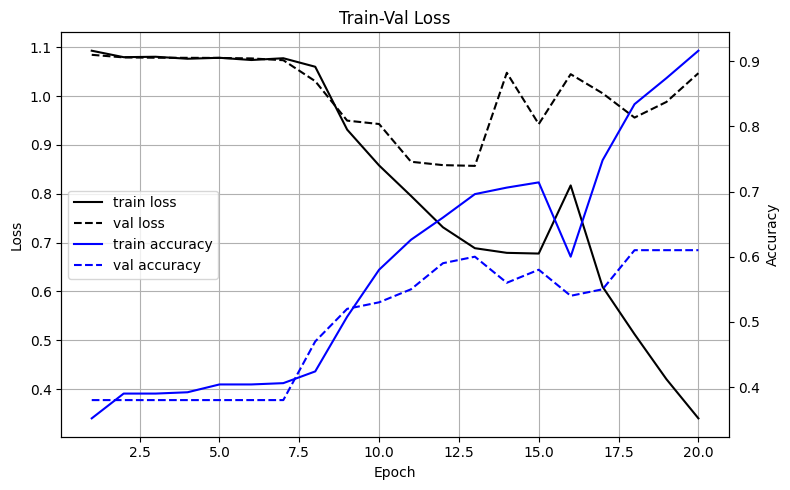

In [ ]:
train_loss = lstm_src.history.history['loss']
val_loss = lstm_src.history.history['val_loss']
train_acc = lstm_src.history.history['accuracy']
val_acc = lstm_src.history.history['val_accuracy']

fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()

ax.plot(np.arange(1, epoch+1), train_loss, label='train loss', color="black", linestyle="-")
ax.plot(np.arange(1, epoch+1), val_loss, label='val loss', color="black", linestyle="--")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax2.plot(np.arange(1, epoch+1), train_acc, label='train accuracy', color="blue", linestyle="-")
ax2.plot(np.arange(1, epoch+1), val_acc, label='val accuracy', color="blue", linestyle="--")
ax2.set_ylabel('Accuracy')

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc=6)

ax.set_title('Train-Val Loss')
ax.grid()

plt.tight_layout()
plt.show()

In [ ]:
# save model
lstm_src.save_weights('lstm_src.weights.h5')

In [17]:
# load model
lstm_src.load_weights('lstm_src.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 56 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
eval = lstm_src.evaluate(x_test_tokenized, y_test_encoded, return_dict=True)
test_acc = eval["accuracy"]
test_loss = eval["loss"]
print(f"Test loss     : {test_loss}")
print(f"Test accuracy : {test_acc}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 346ms/step - accuracy: 0.6451 - loss: 0.8904
Test loss     : 0.8527296185493469
Test accuracy : 0.6650000214576721


In [ ]:
# one hot
ohe = OneHotEncoder()
y_test_encoded_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()

# prediction
y_pred = lstm_src.predict(x_test_tokenized)

# F1 score
metric = F1Score(average="macro")
metric.update_state(y_test_encoded_ohe, y_pred)
test_f1 = metric.result().numpy()
print("Macro F1-score:", test_f1)  # perfect score: 1

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step
Macro F1-score: 0.66030294


In [ ]:
from sklearn.metrics import classification_report
y_pred_labels = np.argmax(y_pred, axis=1)
print(classification_report(y_test_encoded, y_pred_labels))

              precision    recall  f1-score   support

           0       0.57      0.67      0.62       153
           1       0.64      0.57      0.60        96
           2       0.81      0.72      0.76       151

    accuracy                           0.67       400
   macro avg       0.67      0.65      0.66       400
weighted avg       0.68      0.67      0.67       400



## From scratch

In [15]:
batch_size = 24
features = 64
units = 128
rate = 0.4

mod = sequential()
mod.add(embedding(input_dim=max_token, output_dim=features))
mod.add(bidirectional(lstm(units=units, return_seq=True)))
mod.add(bidirectional(lstm(units=int(units*0.7), return_seq=True)))
mod.add(lstm(units=int(units*0.7), return_seq=True))
mod.add(dropout(rate=rate))
mod.add(bidirectional(lstm(units=int(units*0.5), return_seq=True)))
mod.add(lstm(units=int(units*0.5), return_seq=False))
mod.add(dropout(rate=rate))
mod.add(dense(units=3, activation="softmax"))

mod.get_weights("/content/lstm_src.weights.h5")

In [18]:
# one hot
ohe = OneHotEncoder()
y_test_encoded_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()

# prediction
y_scr = mod.predict(x_test_tokenized)
y_keras = lstm_src.predict(x_test_tokenized)

# F1 score scratch
metric = F1Score(average="macro")
metric.update_state(y_test_encoded_ohe, y_scr)
test_f1 = metric.result().numpy()
print("Macro F1-score (scratch):", test_f1)  # perfect score: 1

# F1 score Keras
metric = F1Score(average="macro")
metric.update_state(y_test_encoded_ohe, y_keras)
test_f1 = metric.result().numpy()
print("Macro F1-score (Keras):", test_f1)  # perfect score: 1

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step
Macro F1-score (scratch): 0.66030294
Macro F1-score (Keras): 0.66030294


In [ ]:
from sklearn.metrics import classification_report
y_scr_labels = np.argmax(y_scr, axis=1)
print(classification_report(y_test_encoded, y_scr_labels))

              precision    recall  f1-score   support

           0       0.57      0.67      0.62       153
           1       0.64      0.57      0.60        96
           2       0.81      0.72      0.76       151

    accuracy                           0.67       400
   macro avg       0.67      0.65      0.66       400
weighted avg       0.68      0.67      0.67       400



In [ ]:
from sklearn.metrics import classification_report
y_keras_labels = np.argmax(y_keras, axis=1)
print(classification_report(y_test_encoded, y_keras_labels))

              precision    recall  f1-score   support

           0       0.57      0.67      0.62       153
           1       0.64      0.57      0.60        96
           2       0.81      0.72      0.76       151

    accuracy                           0.67       400
   macro avg       0.67      0.65      0.66       400
weighted avg       0.68      0.67      0.67       400



In [ ]:
masked = (y_scr_labels == y_keras_labels)
print(masked.sum()/len(masked) * 100)

100.0


In [ ]:
mismatch = np.where(~masked)[0]
print(f"mismatch data: {len(mismatch)} data in index: {mismatch}")

mismatch data: 0 data in index: []
